In [2]:
#importing python packages
import panel as pn 
import numpy as np 
import pylab as plt
import pandas as pd 
import pylab as plt 
import matplotlib 
import panel.widgets as pnw
%matplotlib inline

In [3]:
#Reading in the data 
Groups = pd.read_csv('Table1.csv')
Sub_Groups = pd.read_csv('Table2.csv')
Galaxies = pd.read_csv('Table3.csv')

In [4]:
# Defining Useful Functions 


# function to get the alpha and beta values for aitoff plotting 
def get_alpha(Table='Groups',frame='galactic'):
    if frame =='galactic':
        if Table=='Groups':
            alpha, beta = Groups['l'], Groups['b']
        elif Table == 'Galaxies':
            alpha, beta = Galaxies['l'],Galaxies['b']
        else:
            print('Table incorrect')

    elif frame == 'equitorial':
        if Table=='Groups':
            alpha, beta = Groups['Ra'], Groups['Dec']
        elif Table == 'Galaxies':
            alpha, beta = Galaxies['Ra'],Galaxies['Dec']
        else:
            print('Table incorrect')
    else:
        print('frame incorrect')

    return np.array(alpha),np.array(beta)

#function to select Properties from data frames as an array
def get_property(prop,Table='Groups'):
    if Table == 'Groups':
        val_prop = np.array(Groups[prop])
    elif Table == 'Galaxies':
        val_prop = np.array(Galaxies[prop])

    else:
        print('Table not Correct')

    return val_prop

In [5]:
#Defining the main Aitoff plotting function 

# input alpha and beta 0--> 360 and -90 --> 90. Will make changes in the main function
def Aitoff_plot(Table = 'Groups',size_scale=10,size_metric='Nmem',color_metric='V_cmb',
                frame='galactic',alpha=0.5,cmap='magma',grid = True):
    a,b = get_alpha(Table=Table, frame=frame)
    cut = np.where(a>180)[0]
    a[cut] = a[cut]-360 #range alpha from -180 to 180
    a = (np.pi/180)*a 	#convert to radians
    b = (np.pi/180)*b


    sm = get_property(Table=Table,prop=size_metric)
    s = sm*size_scale   #the size of the points can be chosen based on a numerical metric and scaled
    #would be nice to have a scale which is automatically generated

    color= get_property(Table=Table,prop=color_metric)

    #actual plotting
    fig = plt.figure(figsize=(18,15))
    ax = fig.add_subplot(projection='aitoff')
    scatter = ax.scatter(-a,b,s=s,c=color,alpha=alpha,cmap=cmap)
    
    if grid ==True:
        ax.set_xticks(np.arange(-180,210,30)*(np.pi/180))
        xlabels = np.arange(180,-210,-30).astype(str)
        xlabels = [label+r'$^{\degree}$' for label in xlabels]
        ax.set_xticklabels(xlabels)
        ax.grid(color='k')
    elif grid ==False:
        ax.set_xticks([])
        ax.set_yticks([])
    
    #plotting size legend
    if size_metric == 'Dispersion' or size_metric == 'Standard_Deviation':
        size_units = ' [km/s]'
    elif size_metric == 'R200':
        size_units = ' [Mpc]'
    elif size_metric == 'M200':
        size_units = r' [$10^{11} M_{\odot}$]'
    else:
        size_units = ' '
    
    size_legend_sizes = np.linspace(np.min(sm),np.max(sm),5)
    ls = [plt.scatter([],[],s=size_scale*size_legend_size,facecolors='none',edgecolors='k',lw=3) for size_legend_size in size_legend_sizes]
    labels=np.around(size_legend_sizes,2).astype(str)
    leg=plt.legend(ls,labels,bbox_to_anchor=(0.5,-0.3),ncol=5,frameon=False,fontsize=20,handlelength=2,loc=8,scatterpoints=1,title=size_metric+size_units)
    plt.setp(leg.get_title(),fontsize=20)

    #plotting colorbar
    cbar=plt.colorbar(scatter)
    if color_metric == 'V_cmb':
        cbar_label = 'cz [km s$^{-1}$]'
    else:
        cbar_label = '[Mpc]'
    
    
    cbar.set_label(label=cbar_label,fontsize=20)
    cbar.ax.tick_params(labelsize=15)
    plt.tight_layout()
    plt.close()
    return fig


In [6]:
#2MRS Aitoff Tab

#Size Scales
scale_options = np.array([6,7,12,13,14,15])
Scale_By = pnw.Select(name='Scale By: ',value='Nmem',options = list(np.array(Groups.columns)[scale_options]))
Size_Scale = pnw.IntSlider(name='Size scaling factor: ', value=10,start=1,end=200)

#Distance and Colors
distance_options = np.array([9,10,11])
distance = pnw.Select(name='Distance Metric',value = 'V_cmb',options = list(np.array(Groups.columns)[distance_options]))
alpha_values = pnw.FloatSlider(name = 'Alpha Value',start = 0 , end = 1, step = 0.05,value=0.5)

#Aestetic Options
grid_on = pn.widgets.Toggle(name='Grid', button_type='default')
frame_option = pnw.RadioButtonGroup(name='Frame',value = 'galactic',options=['galactic','equitorial'])
cmap_options = pnw.Select(name='Cmap', options=list(matplotlib.cm.cmap_d.keys()))

#Aitoff Plot
@pn.depends(Scale_By,Size_Scale,distance,alpha_values,grid_on,frame_option,cmap_options)
def reactive_aitoff(Scale_By,Size_Scale,distance,alpha_values,grid_on,frame_option,cmap_options):
    return Aitoff_plot(size_metric = Scale_By,size_scale=Size_Scale,color_metric = distance,
                       alpha=alpha_values,grid=grid_on,frame=frame_option,cmap=cmap_options)



Size= pn.Column('##Circle Size:',Scale_By,Size_Scale,background='#f0f0f0')
Color = pn.Column('##Circle Color: ',distance,alpha_values,background='#f0f0f0')
widgets = pn.Column(Size,pn.Spacer(width=300),Color)

options = pn.Column('##Options: ',grid_on,'Frame',frame_option,cmap_options,background='#f0f0f0')

all_widgets = pn.Column(widgets,pn.Spacer(width=300),options)

Tab1 = ('2MRS Aitoff',pn.Row(reactive_aitoff,all_widgets))

In [61]:
# 2MRS Group Catalog Searchable (Tab2)

## check boxes in order to select which columns a person wants
check_boxes = [pnw.Checkbox(name=Data_Column) for Data_Column in list(Groups.columns)]
select_columns = pn.Column('### Columns: ',pn.Column(*check_boxes,background = '#f0f0f0'))

## Distance Range

Type_of_Distance = pnw.Select(name='Type of Distance:',value='Vcmb [km/s]',options=['Vcmb [km/s]',
                                                                'CoMoving [Mpc]',
                                                                'Luminosity [Mpc]'])

min_velocity = pnw.TextInput(name='Min:', placeholder='0.0')
max_velocity = pnw.TextInput(name='Max:', placeholder='1000.')
        
Full_distance = pn.Column('#### Distance Selection:',Type_of_Distance,min_velocity,max_velocity,
                          background = '#f0f0f0')


## Search radius
Frame = pnw.Select(name='Coordinate System:',value='equitorial',options=['equitorial','galactic'])
radius = pnw.TextInput(name='Radius [arcsec]',placeholder='60')
position = pnw.TextInput(name = 'Position', placeholder = '123.456 -23.123')
On_Sky = pn.Column('#### Positional Selection:',Frame,position,radius,background='#f0f0f0')
Cone_search = pn.Column('### Cone Search:',On_Sky,pn.Spacer(width=50),Full_distance)

## Search Button 
search = pn.widgets.Button(name='🔍', width=100)
search_panel = pn.Column(pn.Spacer(width=200),search)


Tab2 = ('Catalog',pn.Row(select_columns,pn.Spacer(width=20),Cone_search,search_panel))



Column
    [0] Markdown(str)
    [1] Tabs
        [0] Row
            [0] ParamFunction(function)
            [1] Column
                [0] Column
                    [0] Column(background='#f0f0f0')
                        [0] Markdown(str)
                        [1] Select(name='Scale By: ', options=['Nmem', 'Nmem_Corrected',...], value='Nmem')
                        [2] IntSlider(end=200, name='Size scaling factor: ', start=1, value=10)
                    [1] Spacer(width=300)
                    [2] Column(background='#f0f0f0')
                        [0] Markdown(str)
                        [1] Select(name='Distance Metric', options=['V_cmb', 'Co_Moving_Dista...], value='V_cmb')
                        [2] FloatSlider(name='Alpha Value', step=0.05, value=0.5)
                [1] Spacer(width=300)
                [2] Column(background='#f0f0f0')
                    [0] Markdown(str)
                    [1] Toggle(name='Grid')
                    [2] Markdown(str)
                    [3] RadioButtonGroup(name='Frame', options=['galactic', '...], value='galactic')
                    [4] Select(name='Cmap', options=['magma', 'inferno', ...], value='magma')
        [1] Row
            [0] Column
                [0] Markdown(str)
                [1] Column(background='#f0f0f0')
                    [0] Checkbox(name='Group_ID')
                    [1] Checkbox(name='Other Names')
                    [2] Checkbox(name='Ra')
                    [3] Checkbox(name='Dec')
                    [4] Checkbox(name='l')
                    [5] Checkbox(name='b')
                    [6] Checkbox(name='Nmem')
                    [7] Checkbox(name='Nmem_Corrected')
                    [8] Checkbox(name='Richness ')
                    [9] Checkbox(name='V_cmb')
                    [10] Checkbox(name='Co_Moving_Distance')
                    [11] Checkbox(name='Luminosity_Distance')
                    [12] Checkbox(name='Dispersion')
                    [13] Checkbox(name='Standard_Deviation')
                    [14] Checkbox(name='R200')
                    [15] Checkbox(name='M200')
                    [16] Checkbox(name='Number_of_Subs')
            [1] Spacer(width=20)
            [2] Column
                [0] Markdown(str)
                [1] Column(background='#f0f0f0')
                    [0] Markdown(str)
                    [1] Select(name='Coordinate System:', options=['equitorial', ...], value='equitorial')
                    [2] TextInput(name='Position', placeholder='123.456 -23.123')
                    [3] TextInput(name='Radius [arcsec]', placeholder='60')
                [2] Spacer(width=50)
                [3] Column(background='#f0f0f0')
                    [0] Markdown(str)
                    [1] Select(name='Type of Distance:', options=['Vcmb [km/s]', ...], value='Vcmb [km/s]')
                    [2] TextInput(name='Min:', placeholder='0.0')
                    [3] TextInput(name='Max:', placeholder='1000.')
            [3] Column
                [0] Spacer(width=200)
                [1] Button(name='🔍', width=100)
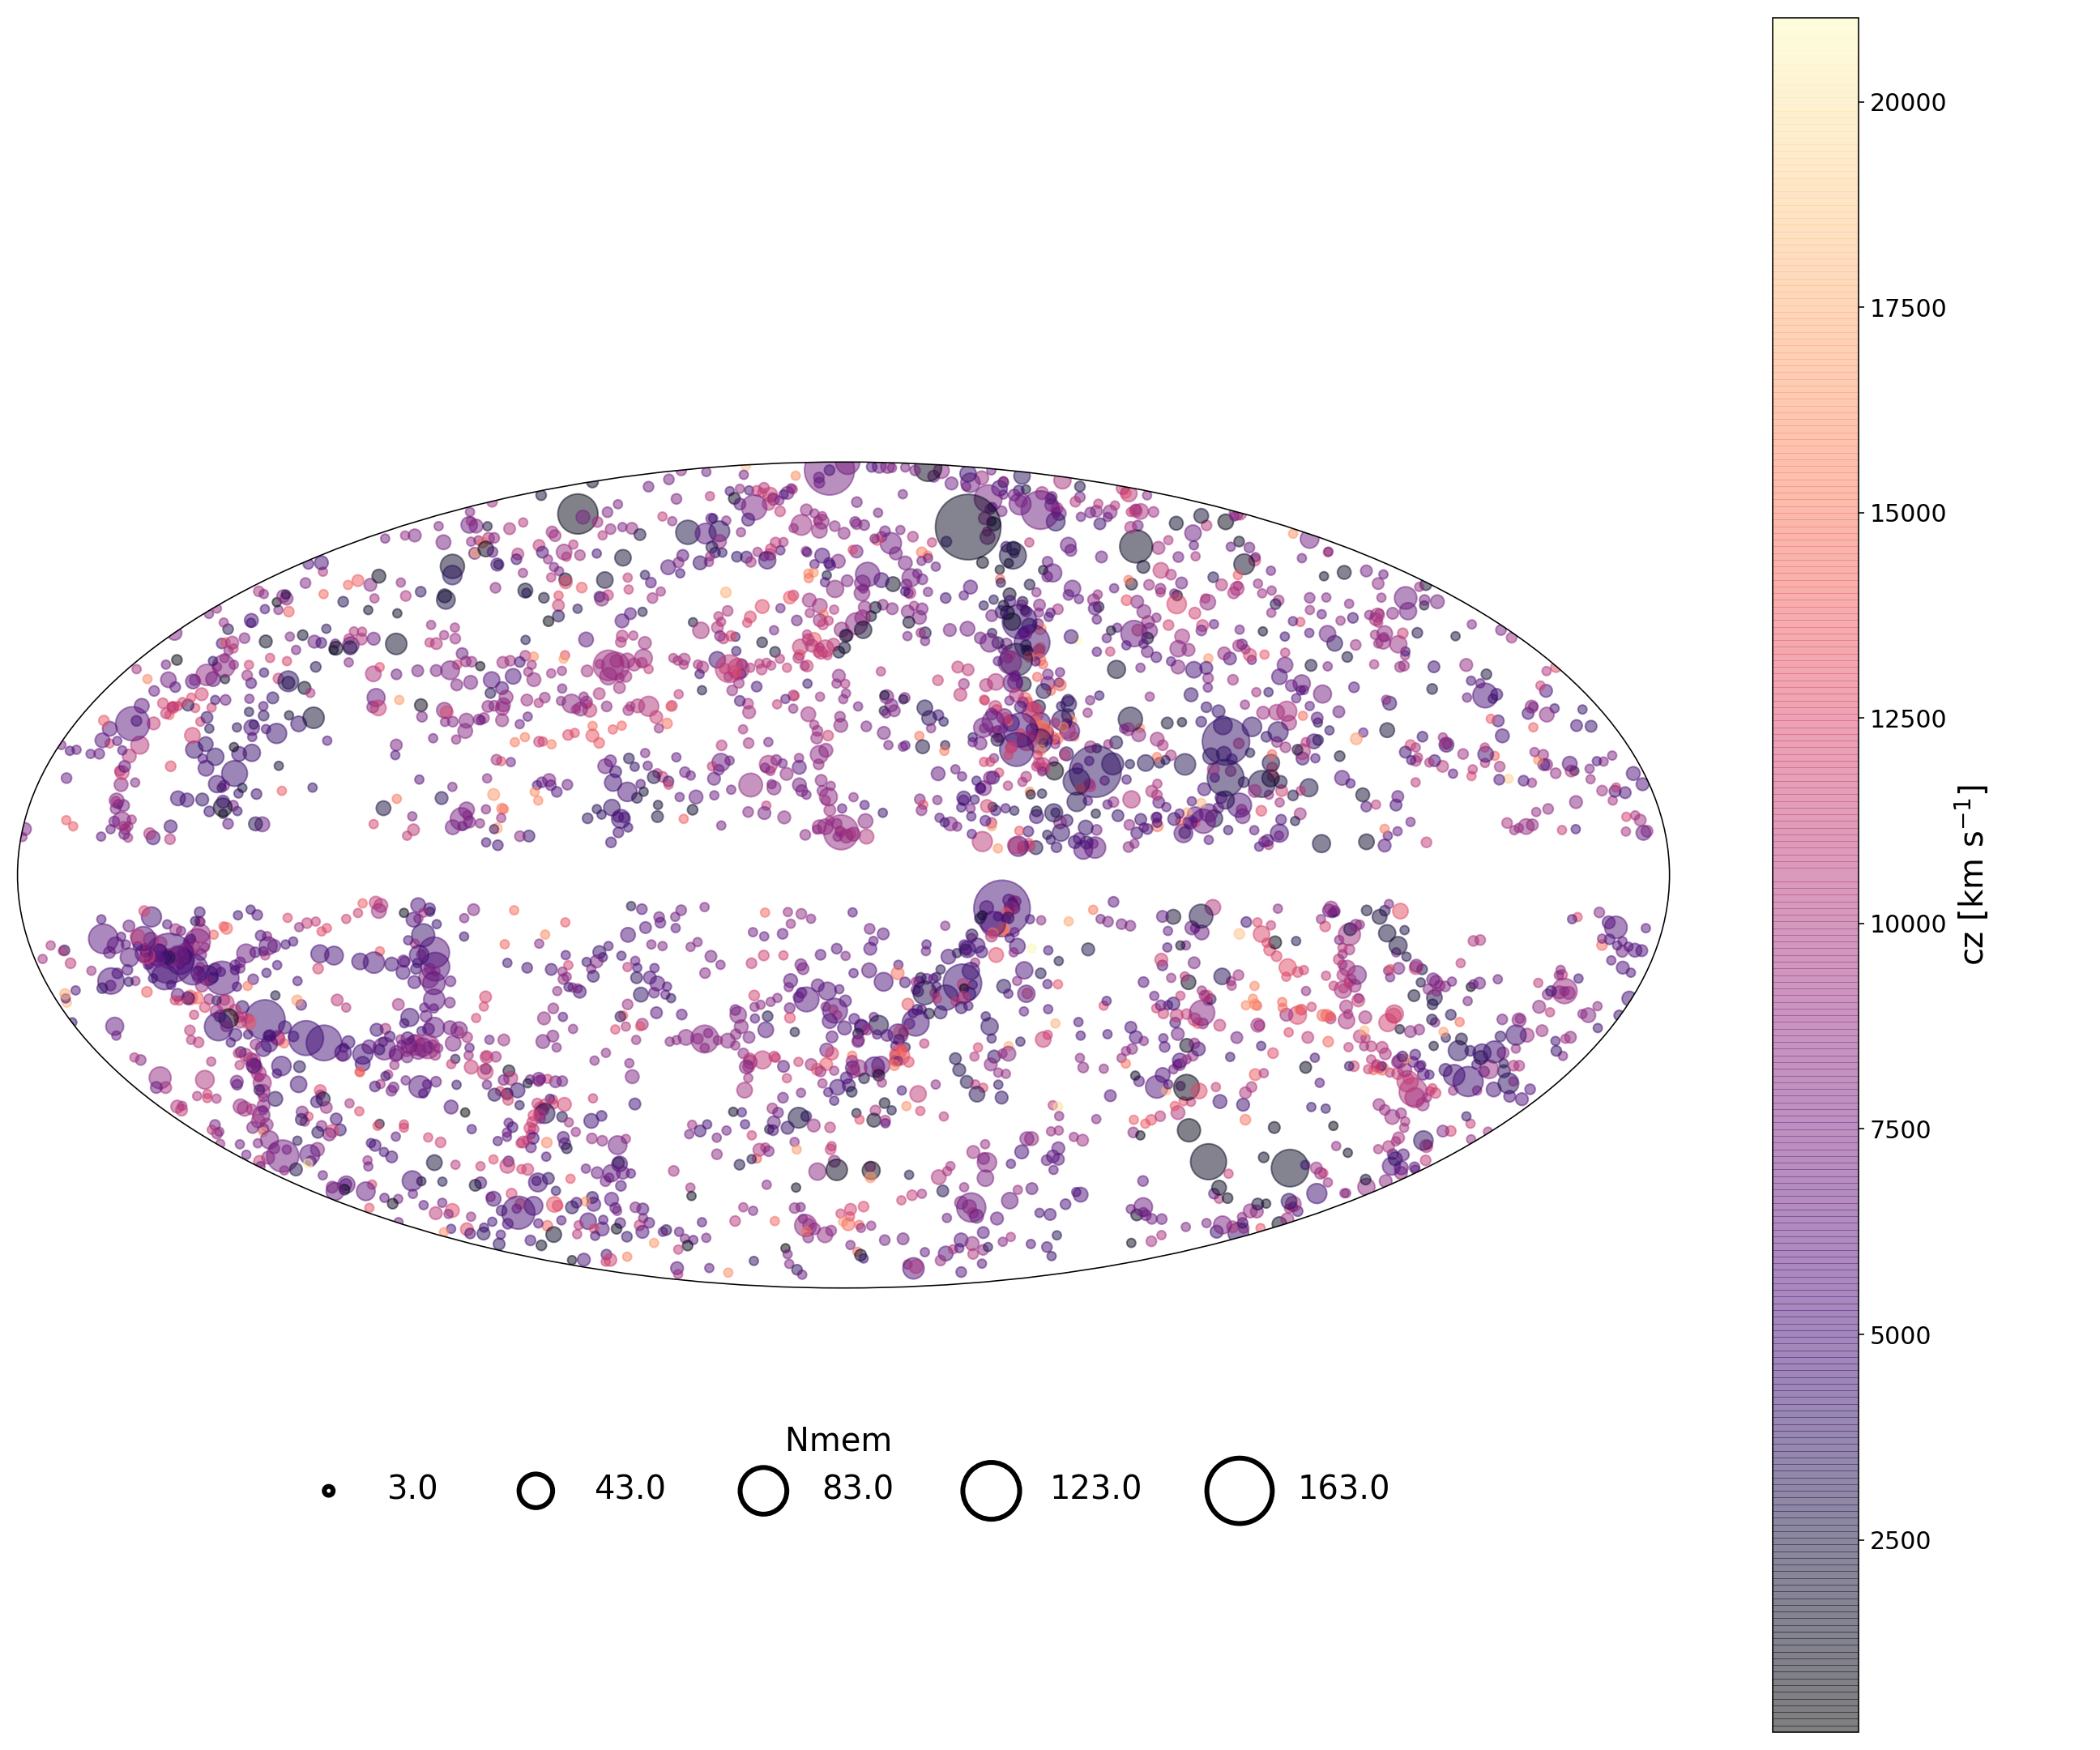

In [62]:
pn.extension()
occupancy = pn.Column('# 2MRS Group Catalog',pn.Tabs(Tab1,Tab2))
occupancy
#occupancy.servable();